In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from ensemble.distributions import distribution_dict
from ensemble.ensemble_model import EnsembleFitter

def ensemble_cdf(x, distributions, weights, mean, variance):
  my_objs = []
  for distribution in distributions:
    my_objs.append(distribution_dict[distribution](mean, variance))
  return sum(weight * distribution.cdf(x) for distribution, weight in zip(my_objs, weights))

def ppf_to_solve(x, q):
  return ensemble_cdf(x, ["normal", "gumbel"], [0.7, 0.3], 0, 1) - q

def ppf_single(q):
  factor = 10.
  left = -factor
  right = factor

  while ppf_to_solve(left, q) > 0:
    left, right = left * factor, left

  while ppf_to_solve(right, q) < 0:
    left, right = right, right * factor

  return scipy.optimize.brentq(ppf_to_solve, left, right, args=q)

def ensemble_rvs(size):
  ppf_vec = np.vectorize(ppf_single, otypes="d")
  unif_samp = scipy.stats.uniform.rvs(size=size)
  return ppf_vec(unif_samp)

ensemble_rvs(10)

array([-0.13232203,  0.43740831, -1.17082002, -0.23752026, -0.29514267,
       -0.12570246, -0.0199769 ,  0.584793  , -1.23747854, -0.87275655])

In [2]:
# std_norm = distribution_dict["normal"](0, 1).rvs(100)
temp = ensemble_rvs(10)
model = EnsembleFitter(["normal", "gumbel"], None)
res = model.fit(temp)
print(res.weights)



# mean = 1
# var = 2
# x = np.linspace(0, 5, 100)
# y = np.linspace(-4, 5, 100)
# std_norm = distribution_dict["normal"](0, 1)
# q = std_norm.ppf(0.05)
# p = std_norm.cdf(q)
# print(q, p)

# a = 0.3
# b = 0.7
# exp = distribution_dict["exponential"](mean, var)
# fisk = distribution_dict["fisk"](mean, var)
# # print(a * exp.(x) + b * norm.pdf(x))

# temp = EnsembleFitter(["exponential", "fisk"], None)
# temp.fit(x)


[0.77402318 0.2793297 ]


working on finding some way to take linear combination of all PDFS and then take draws from that distribution, cant really do that with scipy.stats.rv_continuous.rvs unfortunately

# How does Scipy work?

In [3]:
# helper funcs
def reverse_z(z, mean, variance):
  return z * np.sqrt(variance) + mean

(4.0, 1.0)
0.022750131948179195


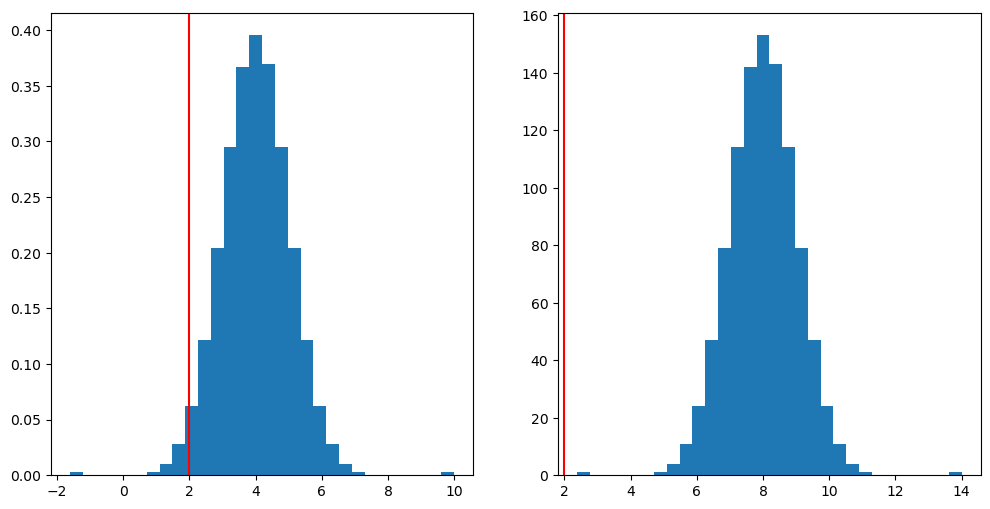

In [4]:
# initialize Normal(0, 1)
MEAN = 4
VARIANCE = 1
std_norm = distribution_dict["normal"](MEAN, VARIANCE)
print(std_norm.stats(moments="mv"))
support_01 = np.linspace(0.00000001, 0.999999999, 1000)
quantiles = std_norm.ppf(support_01)
vals = reverse_z(quantiles, MEAN, VARIANCE)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(quantiles, density=True, bins=30)
quantile = 2
print(std_norm.cdf(quantile))
ax[0].axvline(quantile, color="red")

ax[1].hist(vals, bins=30)
ax[1].axvline(quantile, color="red")
plt.show()





* this shows that cdf and pdf take values from the real line, as if cdf were to take 